In [10]:
# imports
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# set up MPS
device = 'cpu'

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("Current pytorch install wasn't built with MPS enabled")
    else:
        print("MPS is not available")
else:
    device = torch.device("mps")
    print("Using MPS!")

Using MPS!


Just like with my LoRA implementation, we're going to be using the CIFAR10 dataset. This dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. We'll be using the same data augmentation and normalization as the LoRA implementation, so we'll just copy that code over.

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(), # convert image to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize pixel values of image

In [13]:
batch_size = 4 # number of images per batch

# download training dataset, apply transform, and load into DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # load data in batches
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, # download test dataset
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, # load data in batches
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', # class labels
            'dog', 'frog', 'horse', 'ship', 'truck')



100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
# utility function to show one image
def showimg(img):
  """
  Show an image.
  
  :param img: The image to show.
  """
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy array
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose to get correct image orientation
  plt.show()

In [15]:
# get some random training images
dataiter = iter(trainloader) # create an iterator
images, labels = next(dataiter) # get the next batch of images and labels

Just like with LoRA, I'll be creating a simple CNN to classify the images. Let's build something just a bit more complex this time around. We'll use a few convolutional layers, some max pooling, and a few fully connected layers to flatten the convolutional layers and classify the images.

In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # network layers defined below
        self.conv1 = nn.Conv2d(
            3, 6, 5
        ) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2
        self.conv2 = nn.Conv2d(
            6, 16, 5
        ) # 6 input channels, 16 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2
        self.conv3 = nn.Conv2d(
            16, 32, 5
        ) # 16 input channels, 32 output channels, 5x5 kernel
        self.fc1 = nn.Linear(
            16 * 5 * 5, 120
        ) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 84)
        self.fc4 = nn.Linear(84, 84)
        self.fc5 = nn.Linear(84, 10)  # 84 input features, 10 output features

    def forward(self, x):  # define the forward pass
        x = self.pool(F.relu(self.conv1(x)))  # convolve, apply ReLU, then pool
        x = self.pool(F.relu(self.conv2(x)))  # convolve, apply ReLU, then pool
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # apply ReLU
        x = F.relu(self.fc2(x))  # apply ReLU
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)  # output layer
        return x

Throughout this notebook, it will be helpful to be able to print and see all of the layers of the model, as well as which layers are trainable. We'll also want to be able to count trainable and frozen parameters.

In [17]:
def print_params(model: nn.Module):
  """
  Print the number of trainable and untrainable parameters in the model.

  :param model: The model to print the parameters of.
  """
  trainable = 0 # number of trainable parameters
  untrainable = 0 # number of untrainable parameters
  trainable_size = 0 # size in mb of trainable parameters

  print("Layers:")
  for name, param in model.named_parameters():
    print(f"- {name} of size {param.size()} -> {'trainable' if param.requires_grad else 'untrainable'}")

    if param.requires_grad: # if the parameter requires a gradient
      trainable += param.numel() # increment the number of trainable parameters
      trainable_size += param.numel() * param.element_size() # increment the size of trainable parameters
    else: # otherwise
      untrainable += param.numel() # increment the number of untrainable parameters

  print(f"\nTrainable parameters: {trainable}")
  print(f"Untrainable parameters: {untrainable}")
  print(f"Total parameters: {trainable + untrainable}\n")
  print(f"Percent trainable: {100 * trainable / (trainable + untrainable):.2f}%")
  percentage = trainable_size / 1e6
  print(f"Size of trainable parameters: {percentage:.2f} mb")



In [18]:
net = ConvNet() # create a new ConvNet
print_params(net)

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> trainable
- conv1.bias of size torch.Size([6]) -> trainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> trainable
- conv2.bias of size torch.Size([16]) -> trainable
- conv3.weight of size torch.Size([32, 16, 5, 5]) -> trainable
- conv3.bias of size torch.Size([32]) -> trainable
- fc1.weight of size torch.Size([120, 400]) -> trainable
- fc1.bias of size torch.Size([120]) -> trainable
- fc2.weight of size torch.Size([84, 120]) -> trainable
- fc2.bias of size torch.Size([84]) -> trainable
- fc3.weight of size torch.Size([84, 84]) -> trainable
- fc3.bias of size torch.Size([84]) -> trainable
- fc4.weight of size torch.Size([84, 84]) -> trainable
- fc4.bias of size torch.Size([84]) -> trainable
- fc5.weight of size torch.Size([10, 84]) -> trainable
- fc5.bias of size torch.Size([10]) -> trainable

Trainable parameters: 89118
Untrainable parameters: 0
Total parameters: 89118

Percent trainable: 100.00%
Size of trainable param

Alright, now let's train the model.

In [19]:
import torch.optim as optim # package with common optimization algorithms

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # optimizer

In [20]:
def train(model, criterion, optimizer, trainloader, num_epochs=5, device='cpu', announce=2000):
    model.to(device)  # move the model to the device

    for epoch in range(num_epochs):
        running_loss = 0.0  # keep track of running loss
        for i, data in enumerate(trainloader, 0):  # iterate over data
            inputs, labels = data[0].to(device), data[1].to(device)  # get inputs and labels

            # zero the parameter gradients (otherwise they are accumulated)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backward pass
            optimizer.step()  # optimize

            # print statistics
            running_loss += loss.item()
            if i % announce == announce - 1:  # print every announce mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / announce:.3f}")
                running_loss = 0.0
        print(f"Finished epoch {epoch + 1}")

    print('Finished training')

In [21]:
train(net, criterion, optimizer, trainloader, num_epochs=6, device=device)

[1, 2000] loss: 2.304
[1, 4000] loss: 2.303
[1, 6000] loss: 2.301
[1, 8000] loss: 2.213
[1, 10000] loss: 1.920
[1, 12000] loss: 1.801
Finished epoch 1
[2, 2000] loss: 1.652
[2, 4000] loss: 1.594
[2, 6000] loss: 1.547
[2, 8000] loss: 1.497
[2, 10000] loss: 1.453
[2, 12000] loss: 1.416
Finished epoch 2
[3, 2000] loss: 1.376
[3, 4000] loss: 1.332
[3, 6000] loss: 1.334
[3, 8000] loss: 1.318
[3, 10000] loss: 1.286
[3, 12000] loss: 1.278
Finished epoch 3
[4, 2000] loss: 1.223
[4, 4000] loss: 1.197
[4, 6000] loss: 1.197
[4, 8000] loss: 1.168
[4, 10000] loss: 1.195
[4, 12000] loss: 1.174
Finished epoch 4
[5, 2000] loss: 1.111
[5, 4000] loss: 1.106
[5, 6000] loss: 1.094
[5, 8000] loss: 1.085
[5, 10000] loss: 1.085
[5, 12000] loss: 1.086
Finished epoch 5
[6, 2000] loss: 1.020
[6, 4000] loss: 1.032
[6, 6000] loss: 1.033
[6, 8000] loss: 1.033
[6, 10000] loss: 1.017
[6, 12000] loss: 1.021
Finished epoch 6
Finished training


In [22]:
PATH = './cifar_net.pth' # path to save the model
torch.save(net.state_dict(), PATH) # save the model

In [23]:
def test_model(model, testloader, classes):
    """
    Test the model and print out the total accuracy and the accuracy for each class.
    
    Args:
        model: The model to test.
        testloader: The DataLoader for the test data.
        classes: The class labels.
    """
    dataiter = iter(testloader) # create an iterator
    images, labels = next(dataiter) # get the next batch of images and labels

    # print images
    showimg(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    images = images.to(device)
    outputs = net(images) # get the network's predictions

    _, predicted = torch.max(outputs, 1) # get the class with the highest score
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                for j in range(batch_size)))


    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    accuracy_dict = {}

    with torch.no_grad(): # don't compute gradients
        for data in testloader: # iterate over data
            images, labels = data[0].to(device), data[1].to(device) # get inputs and labels
            outputs = model(images) # get the network's predictions
            _, predicted = torch.max(outputs.data, 1) # get the class with the highest score
            total += labels.size(0) # increment total by the number of labels
            correct += (predicted == labels).sum().item() # increment correct by the number of correct predictions

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%\n")

    for i in range(len(classes)):
        print(f"Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")
        accuracy_dict[classes[i]] = 100 * class_correct[i] / class_total[i]

    return accuracy_dict

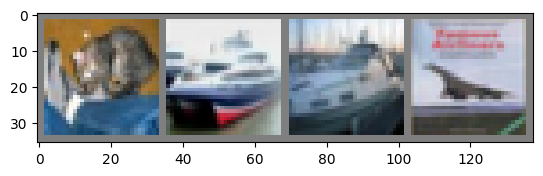

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 62.76%

Accuracy of plane: 71.30%
Accuracy of car: 79.20%
Accuracy of bird: 50.70%
Accuracy of cat: 55.10%
Accuracy of deer: 48.10%
Accuracy of dog: 39.60%
Accuracy of frog: 67.60%
Accuracy of horse: 72.30%
Accuracy of ship: 67.90%
Accuracy of truck: 75.80%


In [24]:
initial_accuracy = test_model(net, testloader, classes)

Alright, let's make our VeRA model.

VeRA is similar to LoRA in that it adds lower-rank auxiliary matrices to the weight matrices of the model. However, instead of training different auxiliary matrix pairs for each linear layer of the model, VeRA shares auxiliary matrices across all same-sized linear layers and trains separate scaling vectors instead.

For example, if a model has the following four linear layers:
- `layer1.shape = (100, 120)`
- `layer2.shape = (120, 120)`
- `layer3.shape = (120, 120)`
- `layer4.shape = (120, 10)`

Three sets of auxiliary matrices A and B will be created -- one for layer 1, one shared between layer2 and layer3, and one for layer4. These auxiliary matrices are always initialized with kaiming uniform initialization.

A set of scaling vectors `d` and `b` will be each layer; `d` will be of shape `(,rank)` and `b` will be of shape `(,out_dim)`, where rank is the common rank between the auxiliary matrices and `out_dim` is the output dimension of the layer. `b` is initialized to 0 and `d` is initialized to some constant (the paper used 1.0).

To compute the output of a layer, the following steps are taken:
- Scale the auxiliary matrices: `A' = Ad, B' = Bd`
- Compute the weight deltas: `dW = A' @ B'`
- Add the weight deltas to the original weights: `W' = W + dW`
- Compute the output of the layer with the auxiliary matrices: `y' = W'x + b`

To train the model, you compute the gradient of the loss with respect to the scaling vectors and then update their values. The auxiliary matrices are not updated.


In [25]:
# let's build out VeRA layer
class VeRALinear(nn.Module):
    """
    This is an implementation of vector-based random matrix adaptation. This is similar to LoRA, with the primary difference being that the low-rank matrices are randomly initialized and frozen, and instead two small vectors b and d are trained.

    Because the low-rank matrices A and B are shared across all layers of the same size, they must be provided as arguments to the constructor.

    :param module: The linear layer module to adapt.
    :param A: The auxiliary matrix A.
    :param B: The auxiliary matrix B.
    """

    def __init__(
            self,
            module: nn.Module,
            A: torch.Tensor,
            B: torch.Tensor,
            d_init: float = 1.0,
    ):
        # ensure that the input module is a linear layer
        assert isinstance(module, nn.Linear), "VeRALinear can only be applied to linear layers"

        super().__init__()
        self.in_dim = module.in_features # input dimension
        self.out_dim = module.out_features # output dimension
        self.A = A # auxiliary matrix A
        self.B = B # auxiliary matrix B
        self.rank = A.shape[1] # rank of the low-rank matrices
        self.d_init = d_init # initial value for d

        # ensure that A and B are of the right shape
        # A should be (in_dim, rank) and B should be (rank, out_dim)
        # where in_dim is module.in_features, out_dim is module.out_features, and rank is the rank of the low-rank matrice
        assert A.shape == (self.in_dim, self.rank), f"A should be of shape {(self.in_dim, self.rank)}"
        assert B.shape == (self.rank, self.out_dim), f"B should be of shape {(self.rank, self.out_dim)}"        

        # recreate the linear layer and freeze it
        # note: we will copy over the pretrained weights after initializing
        self.pretrained = nn.Linear(self.in_dim, self.out_dim, bias=True)
        self.pretrained.weight = nn.Parameter(module.weight.detach().clone())
        self.pretrained.bias = nn.Parameter(module.bias.detach().clone())
        self.pretrained.weight.requires_grad = False # freeze the weights
        self.pretrained.bias.requires_grad = False # freeze the bias

        # initialize the d vector of shape (1, rank) with all values equal to d_init
        self.d = nn.Parameter(torch.full((1, self.rank), d_init))

        # initialize b vector of shape (1, out_dim) with all values equal to 0
        self.b = nn.Parameter(torch.zeros(1, self.out_dim))

        self.d.requires_grad = True
        self.b.requires_grad = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the VeRALinear layer.

        :param x: The input tensor.
        :return: The output tensor.
        """
        # compute the output of the pretrained linear layer
        pretrained_out = self.pretrained(x) # get the pretrained weights

        # scale self.A by self.d; size is (in_dim, rank)
        scaled_A = self.A * self.d.view(1, -1)
        assert scaled_A.shape == (self.in_dim, self.rank), f"scaled_A should be of shape {(self.in_dim, self.rank)}. Got {scaled_A.shape} instead."

        # scale self.B by self.d; size is (rank, out_dim)
        scaled_B = self.B * self.b.view(1, -1)
        assert scaled_B.shape == (self.rank, self.out_dim), f"scaled_B should be of shape {(self.rank, self.out_dim)}. Got {scaled_B.shape} instead."

        out = x @ (scaled_A @ scaled_B)
        assert out.shape == pretrained_out.shape, f"out should be of shape {pretrained_out.shape}. Got {out.shape} instead."

        return pretrained_out + out

Now we need some utility functions. We need to be able to:
- freeze all existing layers in a model
- go through a model and find all linear layers
- generate auxiliary matrices A and B for each group of same-sized linear layers
- turn each linear layer into a VeRA layer with the auxiliary matrices A and B

In the end, we should be able to take any given pytorch model and turn it into a VeRA model.

In [26]:
def freeze_params(model: nn.Module):
    """
    Freeze all parameters in a model.

    :param model: The model to freeze.
    """
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_params(model: nn.Module):
    """
    Unfreeze all parameters in a model.

    :param model: The model to unfreeze.
    """
    for param in model.parameters():
        param.requires_grad = True

def unfreeze_VeRA_vectors(model: nn.Module):
    """
    Unfreeze the d and b vectors in a VeRA model. Recursively calls itself on all children of the model to ensure that all VeRALinear layers in the model have their d and b vectors unfrozen.
    """
    for name, module in model.named_children():
        if isinstance(module, VeRALinear):
            module.d.requires_grad = True
            module.b.requires_grad = True
        else: # recursively call on the module if it is not a VeRALinear layer because it may contain VeRALinear layers
            unfreeze_VeRA_vectors(module)

def countAuxMatrixPairs(model: nn.Module):
    """
    Return the number of unique auxiliary matrix pairs in the model by recursively iterating over all children of the model.
    """
    aux_matrix_pairs = set()
    for name, module in model.named_children():
        if isinstance(module, VeRALinear):
            aux_matrix_pairs.add((module.A, module.B))
        else: # recursively call on the module if it is not a VeRALinear layer because it may contain VeRALinear layers
            aux_matrix_pairs.update(countAuxMatrixPairs(module))
    return aux_matrix_pairs

def createVeRAModel(model: nn.Module, rank: int=4, device: str='cpu', aux_matrices: dict={}):
    """
    Modify a pretrained model in place to create a VeRA model. This is done by modifying each nn.Linear layer in the model to a VeRALinear layer. All nn.Linear layers of the same shape share the same A and B auxiliary matrices.

    :param model: The pretrained model.
    :param device: The device to move the model to.
    """
    # make sure there are no VeRALinear layers in the model; return if there are
    for _, module in model.named_modules():
        if isinstance(module, VeRALinear):
            print("Model already contains VeRALinear layers")
            return
        
    # freeze all parameters in the model
    freeze_params(model)

    # iterate over all layers; determine the set of shapes of all linear layers in the model
    shapes = set()
    for _, module in model.named_children():
        if isinstance(module, nn.Linear):
            shapes.add((module.in_features, module.out_features))
    
    # for each shape, create auxiliary matrices A and B
    # A should be of shape (in_dim, rank) and B should be of shape (rank, out_dim)
    # A and B should both be initialized with kaiming_uniform_
    for shape in shapes:
        in_dim, out_dim = shape
        A = torch.empty((in_dim, rank)).to(device)
        B = torch.empty((rank, out_dim)).to(device)
        nn.init.kaiming_uniform_(A)
        nn.init.kaiming_uniform_(B)
        aux_matrices[shape] = (A, B)

    
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            # get the shape of the current linear layer
            shape = (module.in_features, module.out_features)

            # create the VeRALinear layer
            vera = VeRALinear(module, *aux_matrices[shape])

            # replace the current linear layer with the VeRALinear layer
            setattr(model, name, vera)
            print(f"Replaced {name} with VeRALinear layer")
        else: # recursively call on the module if it is not a linear layer because it may contain linear layers
            createVeRAModel(module, rank, device, aux_matrices)

    # move the model to the device
    model.to(device)

    # unfreeze the d and b vectors in the model
    unfreeze_VeRA_vectors(model)

In [28]:
# create a copy of the existing network
vera_net = ConvNet()

# copy over the pretrained weights
vera_net.load_state_dict(net.state_dict())

# create the VeRA model
createVeRAModel(vera_net, rank=32, device=device)
print_params(vera_net)
print(f"There are {len(countAuxMatrixPairs(vera_net))} unique auxiliary matrix pairs in the model")

Replaced fc1 with VeRALinear layer
Replaced fc2 with VeRALinear layer
Replaced fc3 with VeRALinear layer
Replaced fc4 with VeRALinear layer
Replaced fc5 with VeRALinear layer
Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- conv3.weight of size torch.Size([32, 16, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([32]) -> untrainable
- fc1.d of size torch.Size([1, 32]) -> trainable
- fc1.b of size torch.Size([1, 120]) -> trainable
- fc1.pretrained.weight of size torch.Size([120, 400]) -> untrainable
- fc1.pretrained.bias of size torch.Size([120]) -> untrainable
- fc2.d of size torch.Size([1, 32]) -> trainable
- fc2.b of size torch.Size([1, 84]) -> trainable
- fc2.pretrained.weight of size torch.Size([84, 120]) -> untrainable
- fc2.pretrained.bias of size torch.Size([84]) -> untrainable
- fc3.

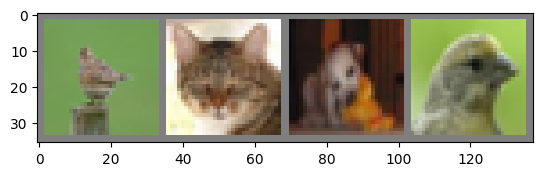

In [29]:
# it looks like the 'cat', 'bird', and 'dog' classes had a low accuracy; let's fine tune the
# vera-adapted model on those classes

# create a new trainset that only contains the cat, bird, and dog classes
new_trainset = [data for data in trainset if data[1] == classes.index('cat') or data[1] == classes.index('bird') or data[1] == classes.index('dog')]

# create a trainloader for only the cat, bird, and dog classes
new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=4, shuffle=True, num_workers=2)

# let's print a few of the cat images# Display some of the cat images
new_dataiter = iter(new_trainloader) # create an iterator
new_images, new_labels = next(new_dataiter) # get the next batch of images and labels

# print images
showimg(torchvision.utils.make_grid(new_images))

In [30]:
# let's continue training the vera-adapted model on just the cat, bird, and dog classes
optimizer = optim.SGD(vera_net.parameters(), lr=0.0001, momentum=0.9) # update the optimizer for the new parameters
train(vera_net, criterion, optimizer, new_trainloader, num_epochs=6, device=device, announce=1000)


[1, 1000] loss: 1.096
[1, 2000] loss: 0.973
[1, 3000] loss: 0.898
Finished epoch 1
[2, 1000] loss: 0.821
[2, 2000] loss: 0.815
[2, 3000] loss: 0.780
Finished epoch 2
[3, 1000] loss: 0.783
[3, 2000] loss: 0.749
[3, 3000] loss: 0.732
Finished epoch 3
[4, 1000] loss: 0.726
[4, 2000] loss: 0.738
[4, 3000] loss: 0.742
Finished epoch 4
[5, 1000] loss: 0.718
[5, 2000] loss: 0.731
[5, 3000] loss: 0.738
Finished epoch 5
[6, 1000] loss: 0.718
[6, 2000] loss: 0.717
[6, 3000] loss: 0.712
Finished epoch 6
Finished training


In [34]:
# double check the params
print_params(vera_net)

# quick check to ensure that the vectors have been trained
for name, param in vera_net.named_parameters():
  if 'b' == name.split('.')[-1]:
    print(f"{name} has all zero weights: {torch.all(param == 0)}")

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- conv3.weight of size torch.Size([32, 16, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([32]) -> untrainable
- fc1.d of size torch.Size([1, 32]) -> trainable
- fc1.b of size torch.Size([1, 120]) -> trainable
- fc1.pretrained.weight of size torch.Size([120, 400]) -> untrainable
- fc1.pretrained.bias of size torch.Size([120]) -> untrainable
- fc2.d of size torch.Size([1, 32]) -> trainable
- fc2.b of size torch.Size([1, 84]) -> trainable
- fc2.pretrained.weight of size torch.Size([84, 120]) -> untrainable
- fc2.pretrained.bias of size torch.Size([84]) -> untrainable
- fc3.d of size torch.Size([1, 32]) -> trainable
- fc3.b of size torch.Size([1, 84]) -> trainable
- fc3.pretrained.weight of size torch.Size([84, 84]) -> untrainable
- fc3.pretraine

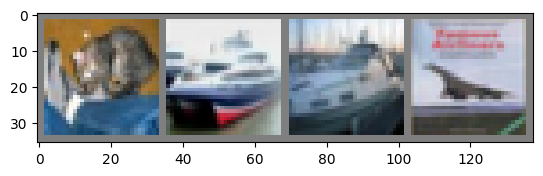

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 33.14%

Accuracy of plane: 3.40%
Accuracy of car: 56.50%
Accuracy of bird: 72.90%
Accuracy of cat: 59.70%
Accuracy of deer: 6.80%
Accuracy of dog: 57.30%
Accuracy of frog: 0.00%
Accuracy of horse: 4.60%
Accuracy of ship: 54.50%
Accuracy of truck: 15.70%


In [32]:
# let's check the accuracy on all classes again; we should see an improvement in the cat class
new_accuracy = test_model(vera_net, testloader, classes)

In [33]:
# compare initial_accuracy and new_accuracy by printing the change in
# accuracy for each class 
for key in initial_accuracy.keys():
  change = new_accuracy[key] - initial_accuracy[key]
  if change > 0:
    print(f"{key}: +{change:.1f}%")
  else:
    print(f"{key}: {change:.1f}%")

plane: -67.9%
car: -22.7%
bird: +22.2%
cat: +4.6%
deer: -41.3%
dog: +17.7%
frog: -67.6%
horse: -67.7%
ship: -13.4%
truck: -60.1%
